<a href="https://colab.research.google.com/github/Sjleerodls/Data_Analysis/blob/main/lab_da/ml19_cnn_exercise_%EC%9D%B4%EC%84%B1%EC%9E%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN  연습

*   Keras 패키지의 손글씨 MNIST 예제 데이터셋을 다운로드하세요.
*   예제 데이터셋의 일부(예: 100개)를 시각화해 보세요.
*   훈련 셋과 테스트 셋의 데이터는 0. ~ 1. 스케일로 스케일링하세요.
*   전체 훈련 셋은 다시 훈련 셋과 검증 셋으로 나누세요.
*   아래의 CNN 모델 구조처럼 합성곱 신경망을 설계하세요.
*   모든 합성곱 층의 커널 사이즈는 3으로 설정하세요.
*   모든 합성곱 층(Conv2D)와 출력층을 제외한 밀집층(Dense)에서
    *   활성화 함수는 ReLU로 설정하세요.
    *   커널 초기화 함수(kernel initialize)를 'he_normal'로 설정하세요.
*   첫번째 Dropout 층의 rate는 0.25로 설정하세요.
*   두번째 Dropout 층의 rate는 0.5로 설정하세요.
*   모델의 옵티마이저(optimizer)는 Nadam을 사용하세요.
*   ModelCheckpoint, EarlyStopping 콜백들과 검증 셋을 함께 사용해서 모델을 훈련하세요.
    *   최적의 모델은 cnn_ex_best.keras 파일로 저장하세요.
*   모델의 성능을 평가하세요.

---

__CNN example__

<img src="https://raw.githubusercontent.com/JakeOh/202505_BD50/refs/heads/main/lab_da/cnn_example_64dpi.png" alt="CNN example" />


# Imports

In [ ]:
import keras

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# MNIST 데이터셋 다운로드

In [ ]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
print(x_train_full.shape)
print(y_train_full.shape)

(60000, 28, 28)
(60000,)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [ ]:
np.unique(y_train_full, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [ ]:
def plot_mnist_image(arr, ncols=10):
    # arr : (n_samples, height, width) 또는 (n_samples, height, width, n_channels)
    n_samples = len(arr)
    nrows = int(np.ceil(n_samples / ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))

    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            if nrows == 1 or ncols == 1:
                if idx < n_samples:
                    ax[idx].imshow(arr[idx], cmap=plt.cm.binary)
                ax[idx].axis('off')
            else:
                if idx < n_samples:
                    ax[i, j].imshow(arr[idx], cmap=plt.cm.binary)
                ax[i, j].axis('off')
    plt.show()

# 데이터셋 일부 시각화

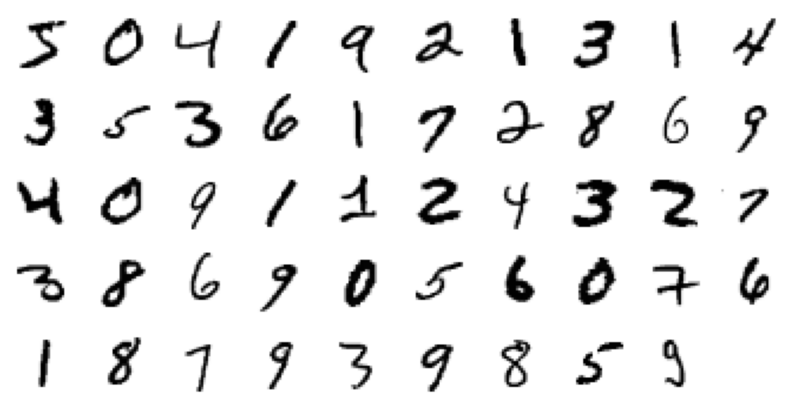

In [ ]:
plot_mnist_image(x_train_full[:49])

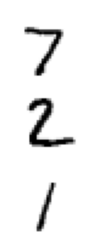

In [ ]:
plot_mnist_image(x_test[:3], ncols=1)

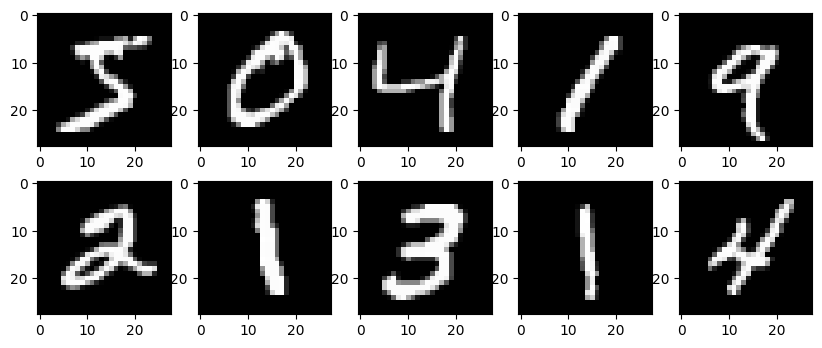

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
  for j in range(5):
    ax[i,j].imshow(x_train_full[i*5+j], cmap='gray')

plt.show()

# 데이터 셋 reshape & scaling

* 이미지 분류 합성곱 신경망에서는 이미지 배열의 모양이 (n_samples, height, width, n_channel)인 3차원 배열이라고 가정.
* 0. ~ 1. 실수 범위인 경우가 성능이 좋음.

In [ ]:
np.max(x_train_full[0]), np.min(x_train_full[0])
#> 첫번째 이미지의 픽섹의 최댓값, 최솟값 -> 0 ~ 255 사이의 부호없는 8비트 정수.

(np.uint8(255), np.uint8(0))

# 훈련 셋과 테스트 셋의 데이터를 0. ~ 1. 스케일링

In [ ]:
x_train_full_scaled = x_train_full.reshape((-1, 28, 28, 1)) / 255.0
x_test_scaled = x_test.reshape((-1, 28, 28, 1)) / 255.0

In [ ]:
print(x_train_full.shape)
print(x_train_full_scaled.shape)

print(y_train_full.shape)

print(x_test.shape)
print(x_test_scaled.shape)

print(y_test.shape)

(60000, 28, 28)
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28)
(10000, 28, 28, 1)
(10000,)


In [ ]:
np.max(x_train_full_scaled), np.min(x_train_full_scaled)

(np.float64(1.0), np.float64(0.0))

# 전체 훈련 셋 다시 훈련 셋과 검증 셋으로 나누기

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full_scaled, y_train_full, test_size=0.2, stratify=y_train_full)

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(48000, 28, 28, 1)
(48000,)
(12000, 28, 28, 1)
(12000,)


# 합성곱 신경망 설계

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential(layers=[
    keras.Input(shape=(28, 28, 1)),     # 입력층
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),  # 첫번째 합성곱
    keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),  # 두번째 합성곱
    keras.layers.MaxPooling2D(),    # Max Pooling
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),   # 밀집층
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=10, activation='softmax')    # 출력층
])

In [ ]:
# Sequential 객체 생성
model = keras.Sequential()

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
model.add(inputs)

In [ ]:
conv2d_init = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')
model.add(conv2d_init)

In [ ]:
conv2d_sec = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')
model.add(conv2d_sec)

In [ ]:
max_pooling2d = keras.layers.MaxPooling2D()
model.add(max_pooling2d)

In [ ]:
model.add(keras.layers.Flatten())

In [ ]:
model.add(keras.layers.Dropout(rate=0.25))

In [ ]:
dense_1 = keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')
model.add(dense_1)

In [ ]:
model.add(keras.layers.Dropout(rate=0.5))

In [ ]:
dense_2 = keras.layers.Dense(units=10, activation='softmax')
model.add(dense_2)

In [ ]:
model.summary()     # shape 과 param이 중요함 !!!

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
14 * 14 * 64 * 128 + 128

1605760

In [ ]:
4 * 1625866 / 1024 / 1024

6.202186584472656

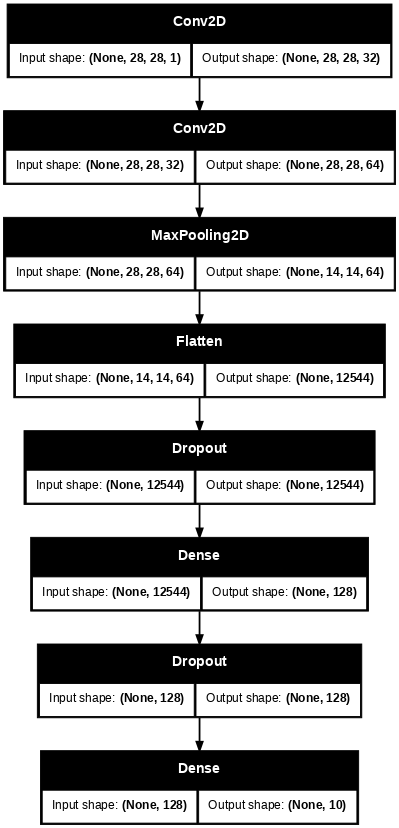

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

# 모델 컴파일
- 모델의 옵티마이저(optimizer)는 Nadam을 사용.

In [ ]:
model.compile(optimizer='nadam', loss=keras.losses.sparse_categorical_crossentropy, metrics=[keras.metrics.sparse_categorical_accuracy])

# 모델 훈련

In [ ]:
from datetime import datetime

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/lab_da/'
file_name = 'cnn_ex_best_v2'
time_suffix = datetime.now().strftime('_%Y%m%d%H%M%S')
file_path = f'{dir_path}{file_name}{time_suffix}.keras'

print(file_path)

/content/drive/MyDrive/Colab Notebooks/lab_da/cnn_ex_best_v2_20250828025504.keras


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(file_path, save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience=2)

In [ ]:
result = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[checkpoint, early_stop])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 112s 73ms/step - loss: 0.4178 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.0610 - val_sparse_categorical_accuracy: 0.9828
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 107s 71ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.0509 - val_sparse_categorical_accuracy: 0.9841
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 150s 76ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.0441 - val_sparse_categorical_accuracy: 0.9872
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 150s 82ms/step - loss: 0.0509 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.0443 - val_sparse_categorical_accuracy: 0.9887
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 129s 73ms/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0430 - val_sparse_categorical_accuracy: 0.9884
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 143s 74ms/step - loss: 0.0371 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0510 - val_spar

In [ ]:
def plot_train_val_loss(history):
    # history : keras의 History 클래스 타입 객체. fit 메서드의 리턴 값.
    epochs = history.epoch
    history = history.history
    plt.plot(epochs, history['loss'], 'bo-', label='loss')
    plt.plot(epochs, history['val_loss'], 'ro:', label='val_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

# 모델 성능 평가

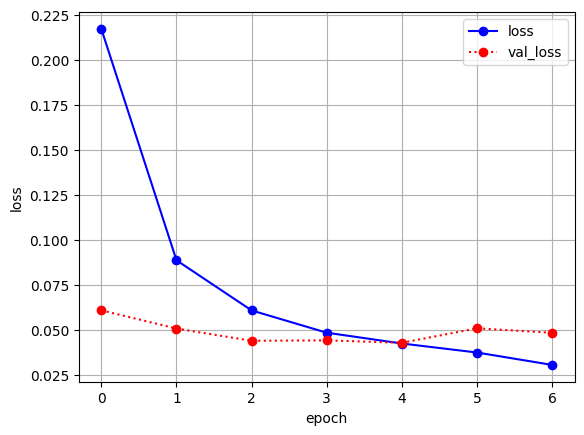

In [ ]:
plot_train_val_loss(result)

In [ ]:
model.evaluate(x_train, y_train)   # 훈련 셋 손실/정확도

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9973


[0.006554474588483572, 0.9978333115577698]

In [ ]:
model.evaluate(x_val, y_val)    # 검증 셋 손실/정확도

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9875


[0.048496313393116, 0.9884999990463257]

In [ ]:
model.evaluate(x=x_test_scaled, y=y_test)    # 테스트 셋 손실/정확도

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9881


[0.04033816605806351, 0.9900000095367432]

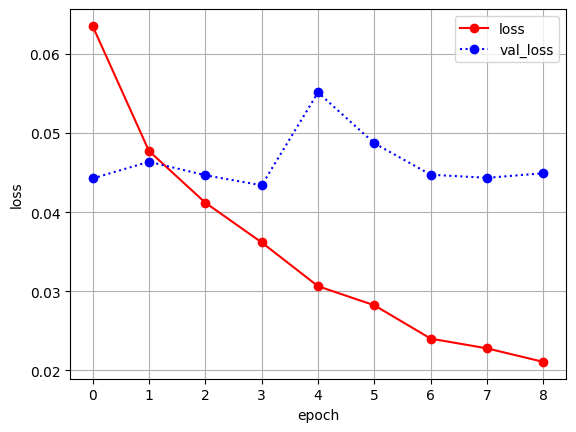

In [ ]:
plt.plot(result.epoch, result.history['loss'], 'ro-', label='loss')
plt.plot(result.epoch, result.history['val_loss'], 'bo:', label='val_loss')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch가 1 ~ 2 사이를 제외하면 나머지 부분은 과대적합이 매우 크게 일어남.

# CNN 연습 2

* Fashion MNIST 데이터 셋
* CNN 구조
    * Conv2D(filters=64, kernel_size=7)  
    * MaxPool2D
    * Conv2D(filters=128, kernel_size=3)
    * Conv2D(filters=128, kernel_size=3)
    * MaxPool2D
    * Conv2D(filters=256, kernel_size=3)
    * Conv2D(filters=256, kernel_size=3)
    * MaxPool2D
    * Flatten
    * Dense(units=128)
    * Dropout(rate=0.5)
    * Dense(units=64)
    * Dropout(rate=0.5)
    * Dense(units=?)    - 출력층
    * 출력층을 제외한 층(Conv2D, Dense)들의 활성화 함수는 relu
    * 합성곱은 same 패딩 방식.
    * 커널 초기화 함수는 'he_normal'

## Imports

In [1]:
import keras

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

## Fashion MNIST 데이터셋 불러오기

In [2]:
fashion = keras.datasets.fashion_mnist.load_data()

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [4]:
print(x_train_full.shape)
print(y_train_full.shape)

(60000, 28, 28)
(60000,)


In [5]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


## 데이터셋 일부 시각화

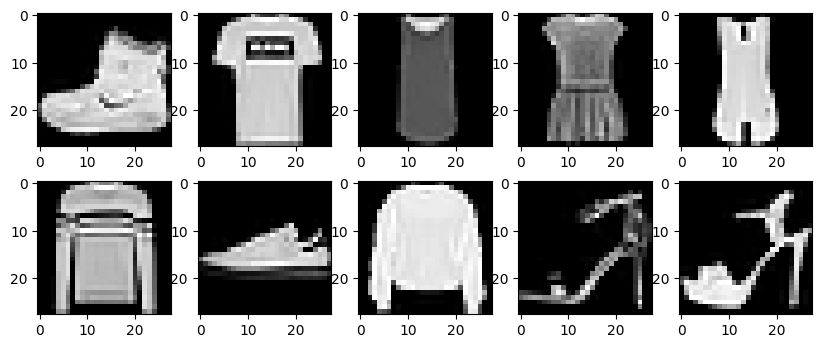

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
  for j in range(5):
    ax[i,j].imshow(x_train_full[i*5+j], cmap='gray')

plt.show()

## 데이터셋 reshape & scaling

In [7]:
x_train_full_scaled = x_train_full.reshape((-1, 28, 28, 1)) / 255.0
x_test_scaled = x_test.reshape((-1, 28, 28, 1)) / 255.0

In [8]:
print(x_train_full_scaled.shape)
print(x_test_scaled.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 전체 데이터셋 훈련/검증 셋으로 나누기

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full_scaled, y_train_full, test_size=0.2, stratify=y_train_full)

In [10]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(48000, 28, 28, 1)
(48000,)
(12000, 28, 28, 1)
(12000,)


## 합성곱 신경망 생성

In [11]:
model = keras.Sequential(layers=[
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same', kernel_initializer='he_normal'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=20, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,414,484 (5.40 MB)

 Trainable params: 1,414,484 (5.40 MB)

 Non-trainable params: 0 (0.00 B)

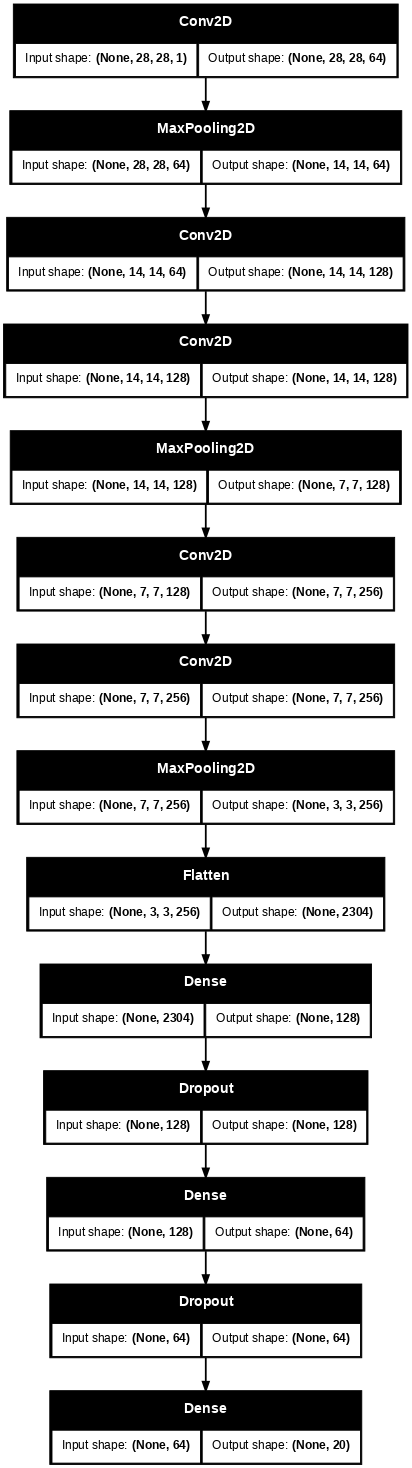

In [13]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

## 모델 컴파일

In [14]:
model.compile(optimizer='nadam', loss=keras.losses.sparse_categorical_crossentropy, metrics=[keras.metrics.sparse_categorical_accuracy])

## 모델 훈련

In [15]:
from datetime import datetime

In [16]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/lab_da/'
file_name = 'cnn_exercise_num2'
time_suffix = datetime.now().strftime('_%Y%m%d%H%M%S')
file_path = f'{dir_path}{file_name}{time_suffix}.keras'

In [17]:
checkpoint = keras.callbacks.ModelCheckpoint(file_path, save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience=3)

In [18]:
result = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[checkpoint, early_stop])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 1.3437 - sparse_categorical_accuracy: 0.5514 - val_loss: 0.3807 - val_sparse_categorical_accuracy: 0.8652
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.4812 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.3279 - val_sparse_categorical_accuracy: 0.8801
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.3979 - sparse_categorical_accuracy: 0.8635 - val_loss: 0.3077 - val_sparse_categorical_accuracy: 0.8927
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.3547 - sparse_categorical_accuracy: 0.8826 - val_loss: 0.2911 - val_sparse_categorical_accuracy: 0.8998
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.3219 - sparse_categorical_accuracy: 0.8931 - val_loss: 0.2896 - val_sparse_categorical_accuracy: 0.8998
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.2906 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.2671 - val_sparse_categ

## 모델 평가

In [19]:
def plot_train_val_loss(history):
    # history : keras의 History 클래스 타입 객체. fit 메서드의 리턴 값.
    epochs = history.epoch
    history = history.history
    plt.plot(epochs, history['loss'], 'bo-', label='loss')
    plt.plot(epochs, history['val_loss'], 'ro:', label='val_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

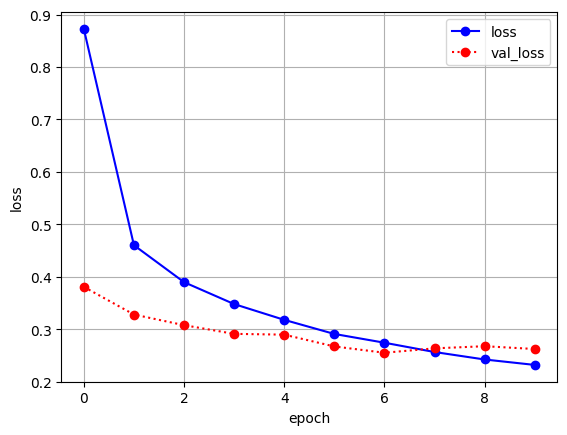

In [20]:
plot_train_val_loss(result)

In [21]:
model.evaluate(x_train, y_train)    # 훈련 셋 손실/정확도

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.9448


[0.14829857647418976, 0.9446458220481873]

In [22]:
model.evaluate(x_val, y_val)        # 검증 셋 손실/정확도

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2714 - sparse_categorical_accuracy: 0.9126


[0.2622066140174866, 0.9133333563804626]

In [23]:
model.evaluate(x_test_scaled, y_test)      # 테스트 셋 손실/정확도

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3062 - sparse_categorical_accuracy: 0.9082


[0.2869725525379181, 0.9110000133514404]